### Imports and Setup
Ensure you have CUDA 10.0, CUDA Tookit, cuDNN SDK (>= 7.4.1) 
https://www.tensorflow.org/install/gpu#software_requirements

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout



%matplotlib inline
tf.__version__

'2.0.0-rc1'

In [2]:
!kaggle datasets list -s pneumonia

ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
paultimothymooney/chest-xray-pneumonia                            Chest X-Ray Images (Pneumonia)                        2GB  2018-03-24 19:41:59          23629        715  0.75             
parthachakraborty/pneumonia-chest-x-ray                           Pneumonia Chest X ray                                 1GB  2018-08-16 07:48:39            362         12  0.5              
vaillant/rsna-pneu-train-png                                      RSNA Pneumonia Detection Challenge Train PNGs         9GB  2018-09-21 00:02:41            198         10  0.375            
nih-chest-xrays/data                              

 #### Change below to a code cell to download datasets (see https://www.kaggle.com/docs/api) 

In [3]:
dataset_path = "./chest-xray-pneumonia/chest_xray/"
train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

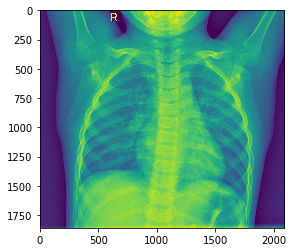

In [4]:
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

In [5]:
'''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)

Optional:
labeled: boolean, determine if images should be labeled
sample_size: int, number of images to display
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)

0:train
0:PNEUMONIA
1:NORMAL
1:test
0:PNEUMONIA
1:NORMAL


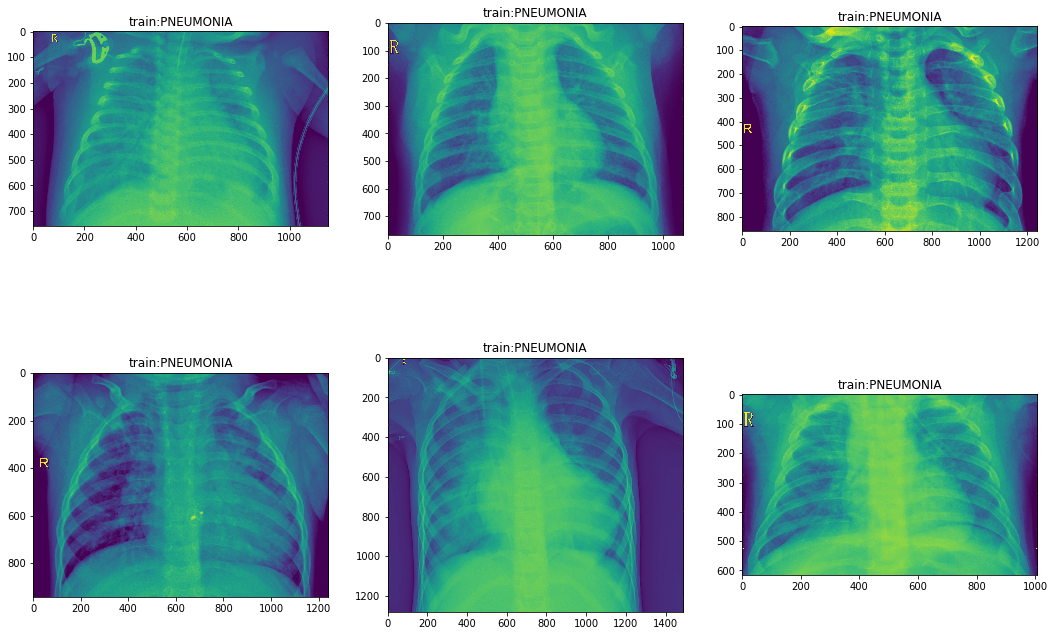

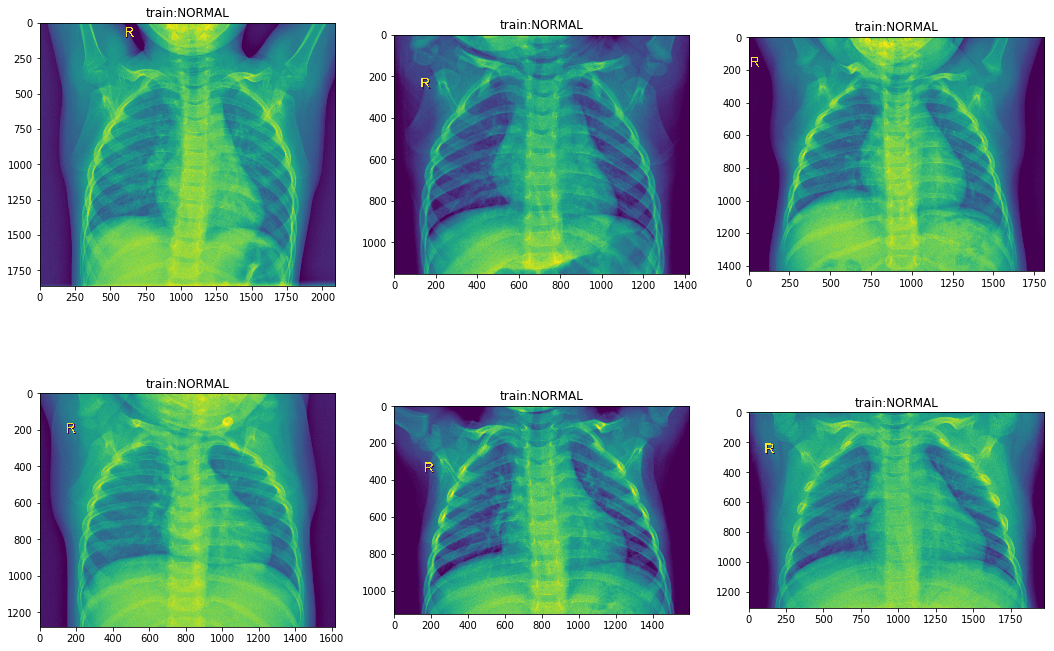

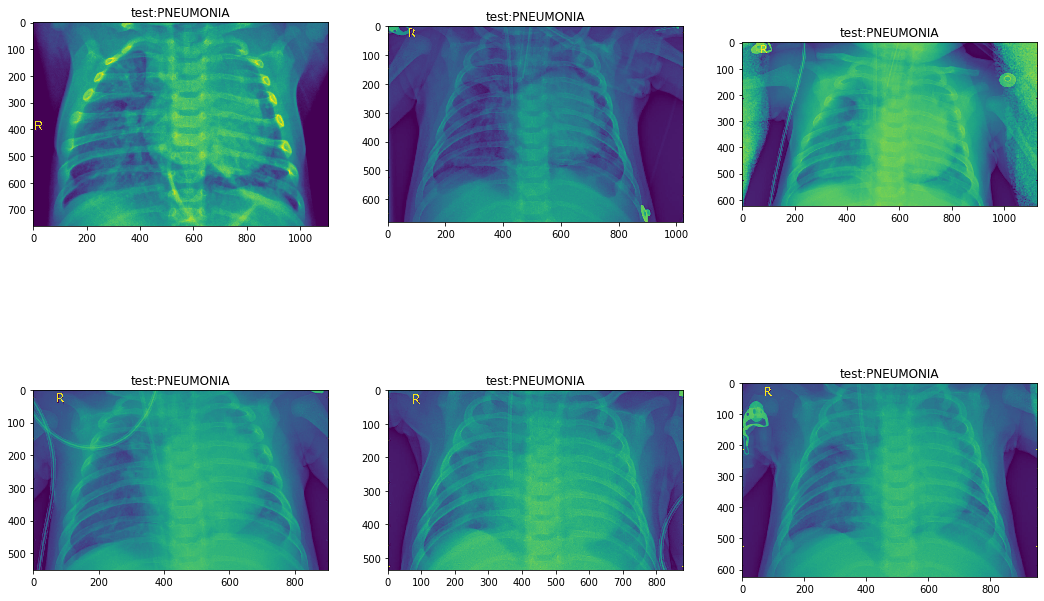

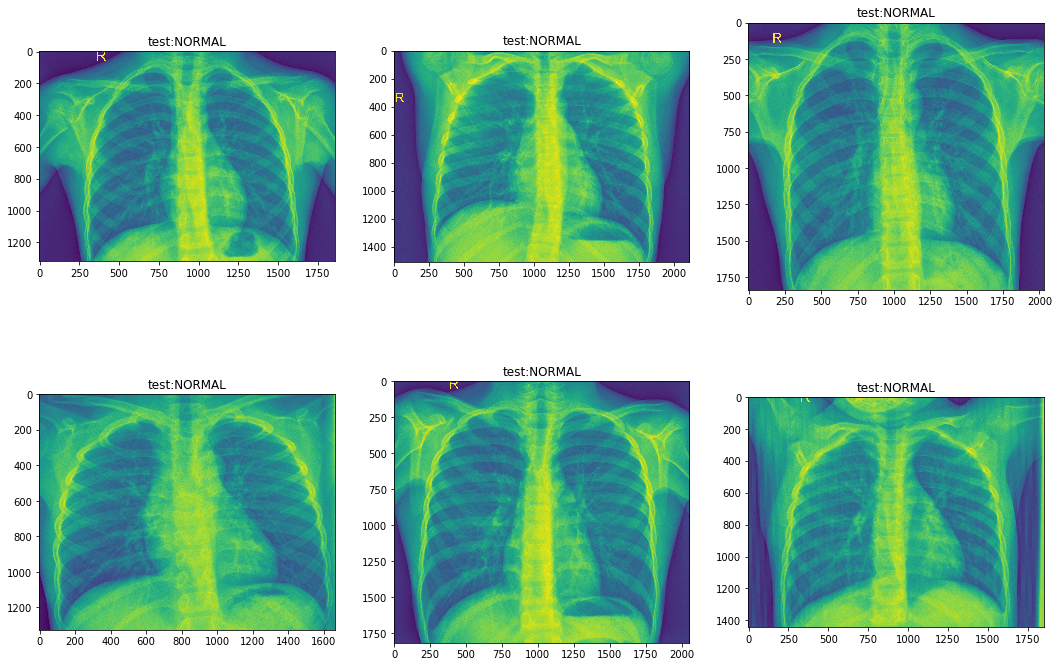

In [6]:
subsetDict = {'train':['PNEUMONIA','NORMAL'],'test':['PNEUMONIA','NORMAL']}

for x,y in enumerate(subsetDict):
    print(f'{x}:{y}')
    for a,b in enumerate(subsetDict[y]):
        print(f'{a}:{b}')

def plt_test(sub):
    for x,y in enumerate(sub):
        for a,b in enumerate(sub[y]):
            subset = y
            category = b
            full_path = dataset_path + subset + '/' + category
            plt.figure(figsize=(18,12))
            for i, file in enumerate(os.listdir(full_path)):
                if not (i >= 6):
                    img = mpimg.imread(full_path +'/'+file)
                    plt.subplot(231+i)
                    plt.title(y+':'+b)
                    plt.imshow(img)
                    
plt_test(subsetDict)


In [7]:
def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))

  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
    
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')  
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)

  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  plt.show()

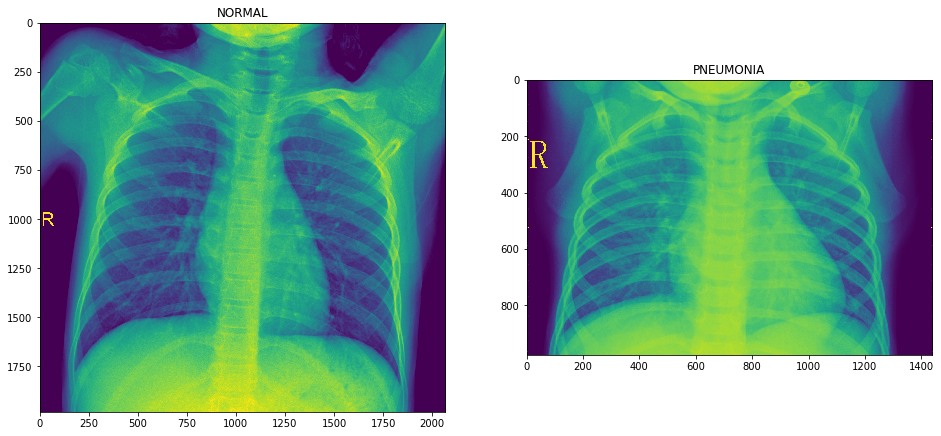

In [8]:
# comparing
compare_img("train", labeled = True)

### Modeling

In [9]:
IMG_SHAPE = (150, 150, 3)

In [10]:
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")

In [11]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 16, 16, 256)  0           activation_5[0][0]               
                                                                 activation_7[0][0]               
                                                                 activation_10[0][0]              
                                                                 activation_11[0][0]              
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 16, 16, 64)   192         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 16, 16, 64)   192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 16, 16, 64)   192         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 16, 16, 96)   288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 16, 16, 64)   192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 16, 16, 64)   0           batch_normalization_19[0][0]     
__________

batch_normalization_37 (BatchNo (None, 7, 7, 128)    384         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 7, 7, 128)    0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 7, 7, 128)    0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 7, 7, 768)    0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 7, 7, 192)    147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_33 

__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 7, 7, 192)    576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 7, 7, 192)    576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 7, 7, 192)    576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 7, 7, 192)    576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 7, 7, 192)    0           batch_normalization_40[0][0]     
__________

activation_59 (Activation)      (None, 7, 7, 192)    0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 7, 7, 768)    0           activation_50[0][0]              
                                                                 activation_53[0][0]              
                                                                 activation_58[0][0]              
                                                                 activation_59[0][0]              
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 7, 7, 192)    147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 7, 7, 192)    576         conv2d_64[0][0]                  
__________

batch_normalization_73 (BatchNo (None, 7, 7, 192)    576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 7, 7, 192)    0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 7, 7, 192)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 7, 7, 192)    258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 7, 7, 192)    576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_83 (Activation)      (None, 3, 3, 384)    0           batch_normalization_83[0][0]     
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 3, 3, 192)    576         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 3, 3, 320)    0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 3, 3, 768)    0           activation_78[0][0]              
                                                                 activation_79[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3, 3, 768)    0           activation_82[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [12]:
#Freeze base model
base_model.trainable = False

In [13]:
base_model.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 3, 3, 2048) dtype=float32>

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [15]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Identity:0' shape=(None, 2048) dtype=float32>

In [16]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

In [17]:
# Define the model
model = tf.keras.models.Model(inputs=base_model.input,outputs=prediction_layer)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 16, 16, 256)  0           activation_5[0][0]               
                                                                 activation_7[0][0]               
                                                                 activation_10[0][0]              
                                                                 activation_11[0][0]              
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 16, 16, 64)   192         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 16, 16, 64)   192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 16, 16, 64)   192         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 16, 16, 96)   288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 16, 16, 64)   192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 16, 16, 64)   0           batch_normalization_19[0][0]     
__________

batch_normalization_37 (BatchNo (None, 7, 7, 128)    384         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 7, 7, 128)    0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 7, 7, 128)    0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 7, 7, 768)    0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 7, 7, 192)    147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_33 

__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 7, 7, 192)    576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 7, 7, 192)    576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 7, 7, 192)    576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 7, 7, 192)    576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 7, 7, 192)    0           batch_normalization_40[0][0]     
__________

activation_59 (Activation)      (None, 7, 7, 192)    0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 7, 7, 768)    0           activation_50[0][0]              
                                                                 activation_53[0][0]              
                                                                 activation_58[0][0]              
                                                                 activation_59[0][0]              
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 7, 7, 192)    147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 7, 7, 192)    576         conv2d_64[0][0]                  
__________

batch_normalization_73 (BatchNo (None, 7, 7, 192)    576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 7, 7, 192)    0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 7, 7, 192)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 7, 7, 192)    258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 7, 7, 192)    576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_83 (Activation)      (None, 3, 3, 384)    0           batch_normalization_83[0][0]     
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 3, 3, 192)    576         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 3, 3, 320)    0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 3, 3, 768)    0           activation_78[0][0]              
                                                                 activation_79[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3, 3, 768)    0           activation_82[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1049088     global_average_pooling2d[0][0]   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (D

In [19]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss="categorical_crossentropy",metrics = ["accuracy"])

In [20]:
# Data generators
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [21]:
train_generator = data_gen_train.flow_from_directory(
    train_dir,target_size=(150,150),batch_size=128,class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [22]:
valid_generator = data_gen_valid.flow_from_directory(
    validation_dir,target_size=(150,150),batch_size=128,class_mode="categorical")

Found 16 images belonging to 2 classes.


In [23]:
test_generator = data_gen_valid.flow_from_directory(
    test_dir,target_size=(150,150),batch_size=128, class_mode="categorical")

Found 624 images belonging to 2 classes.


In [24]:
model.fit_generator(
    train_generator, epochs=5, validation_data=valid_generator)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - ETA: 4:00 - loss: 0.7583 - accuracy: 0.49 - ETA: 2:23 - loss: 0.6976 - accuracy: 0.58 - ETA: 1:38 - loss: 0.6822 - accuracy: 0.61 - ETA: 1:16 - loss: 0.6748 - accuracy: 0.63 - ETA: 1:02 - loss: 0.6600 - accuracy: 0.64 - ETA: 53s - loss: 0.6524 - accuracy: 0.6644 - ETA: 49s - loss: 0.6498 - accuracy: 0.670 - ETA: 47s - loss: 0.6392 - accuracy: 0.685 - ETA: 45s - loss: 0.6406 - accuracy: 0.689 - ETA: 44s - loss: 0.6380 - accuracy: 0.693 - ETA: 42s - loss: 0.6297 - accuracy: 0.697 - ETA: 41s - loss: 0.6211 - accuracy: 0.706 - ETA: 39s - loss: 0.6171 - accuracy: 0.706 - ETA: 38s - loss: 0.6126 - accuracy: 0.711 - ETA: 36s - loss: 0.6094 - accuracy: 0.712 - ETA: 35s - loss: 0.6058 - accuracy: 0.714 - ETA: 34s - loss: 0.6022 - accuracy: 0.718 - ETA: 32s - loss: 0.5977 - accuracy: 0.723 - ETA: 31s - loss: 0.5947 - accuracy: 0.726 - ETA: 30s - loss: 0

41/41 [==============================] - ETA: 41s - loss: 0.1800 - accuracy: 0.906 - ETA: 44s - loss: 0.2058 - accuracy: 0.898 - ETA: 45s - loss: 0.2298 - accuracy: 0.893 - ETA: 44s - loss: 0.2398 - accuracy: 0.890 - ETA: 43s - loss: 0.2274 - accuracy: 0.900 - ETA: 42s - loss: 0.2312 - accuracy: 0.895 - ETA: 40s - loss: 0.2224 - accuracy: 0.902 - ETA: 39s - loss: 0.2203 - accuracy: 0.905 - ETA: 38s - loss: 0.2099 - accuracy: 0.910 - ETA: 37s - loss: 0.2126 - accuracy: 0.909 - ETA: 36s - loss: 0.2109 - accuracy: 0.908 - ETA: 34s - loss: 0.2063 - accuracy: 0.910 - ETA: 33s - loss: 0.2026 - accuracy: 0.914 - ETA: 32s - loss: 0.1980 - accuracy: 0.915 - ETA: 30s - loss: 0.1977 - accuracy: 0.916 - ETA: 29s - loss: 0.2009 - accuracy: 0.916 - ETA: 27s - loss: 0.2001 - accuracy: 0.915 - ETA: 26s - loss: 0.2032 - accuracy: 0.913 - ETA: 25s - loss: 0.1977 - accuracy: 0.917 - ETA: 24s - loss: 0.1972 - accuracy: 0.917 - ETA: 23s - loss: 0.1966 - accuracy: 0.919 - ETA: 22s - loss: 0.1985 - accuracy:

### Transfer learning tests

In [26]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.625


In [27]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

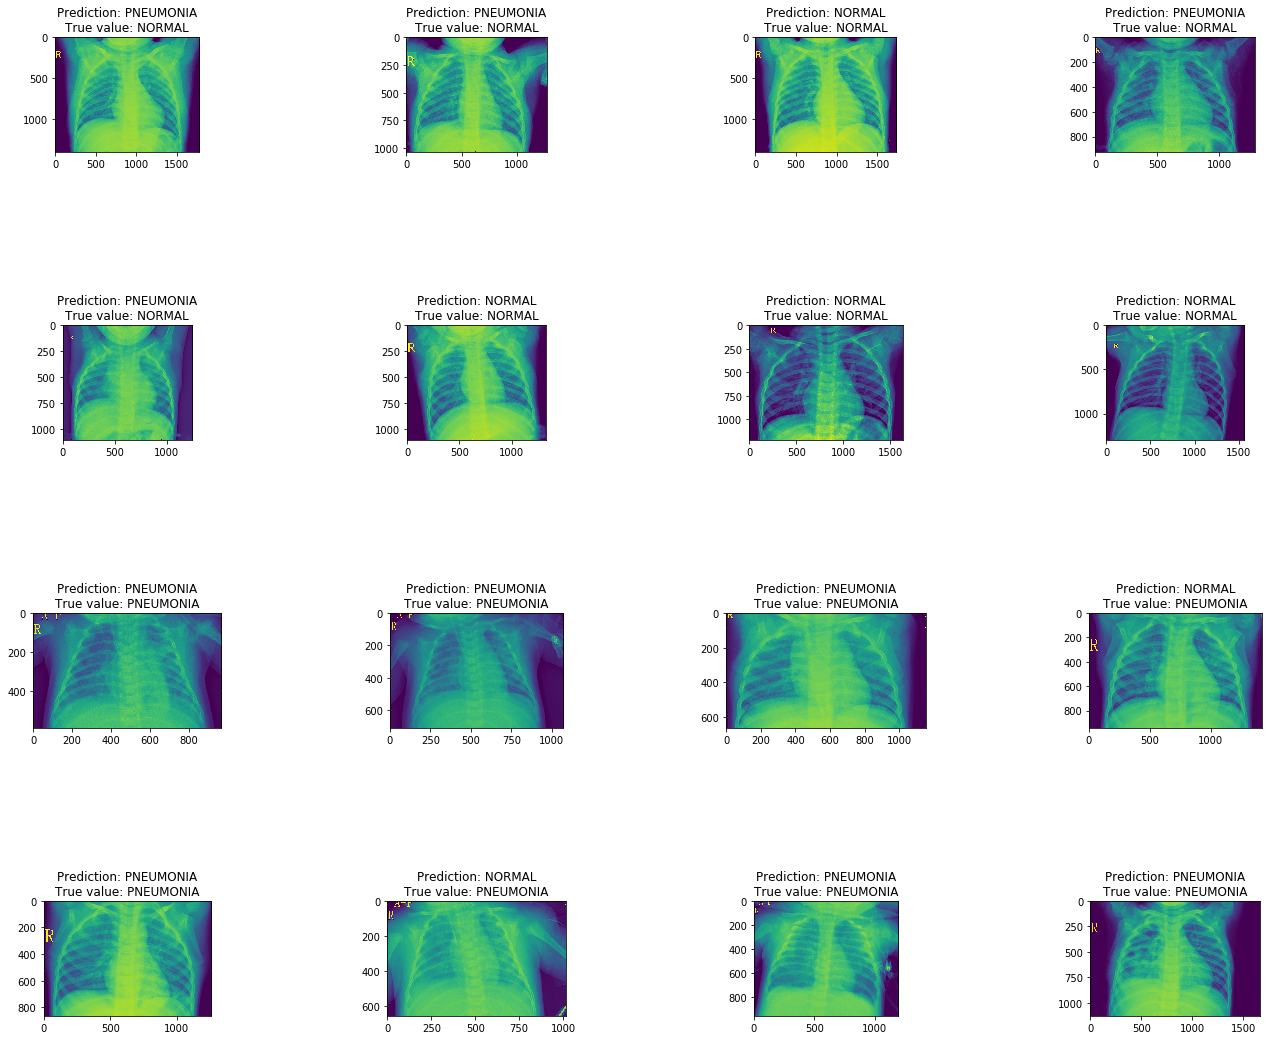

In [28]:
compare_results(validation_dir, valid_generator)

### Save the model

In [31]:
import json

model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("Saved model to local directory as:\r\narchitecture.json\r\nmodel.h5")

Saved model to local directory as:
architecture.json
model.h5


### Unfreeze top layers for tuning

In [32]:
base_model.trainable = True
print("Number of layers in the base model: {}".format(len(base_model.layers)))
fine_tune_at = 200
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 311


### Compile for tuning

In [33]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Tuning

In [34]:
model.fit_generator(generator = train_generator,epochs=5,validation_data=valid_generator)

Epoch 1/5
41/41 [==============================] - ETA: 1:15 - loss: 0.2266 - accuracy: 0.91 - ETA: 54s - loss: 0.2578 - accuracy: 0.9141 - ETA: 50s - loss: 0.2533 - accuracy: 0.908 - ETA: 47s - loss: 0.2318 - accuracy: 0.910 - ETA: 44s - loss: 0.2248 - accuracy: 0.910 - ETA: 42s - loss: 0.2143 - accuracy: 0.915 - ETA: 40s - loss: 0.1977 - accuracy: 0.920 - ETA: 40s - loss: 0.1965 - accuracy: 0.919 - ETA: 39s - loss: 0.1941 - accuracy: 0.920 - ETA: 37s - loss: 0.1967 - accuracy: 0.921 - ETA: 36s - loss: 0.1947 - accuracy: 0.921 - ETA: 35s - loss: 0.1867 - accuracy: 0.926 - ETA: 34s - loss: 0.1854 - accuracy: 0.927 - ETA: 33s - loss: 0.1899 - accuracy: 0.926 - ETA: 31s - loss: 0.1880 - accuracy: 0.925 - ETA: 30s - loss: 0.1825 - accuracy: 0.928 - ETA: 29s - loss: 0.1793 - accuracy: 0.930 - ETA: 27s - loss: 0.1752 - accuracy: 0.931 - ETA: 26s - loss: 0.1776 - accuracy: 0.930 - ETA: 25s - loss: 0.1759 - accuracy: 0.931 - ETA: 24s - loss: 0.1733 - accuracy: 0.933 - ETA: 22s - loss: 0.1702 

41/41 [==============================] - ETA: 35s - loss: 0.0011 - accuracy: 1.000 - ETA: 41s - loss: 0.0066 - accuracy: 0.996 - ETA: 41s - loss: 0.0053 - accuracy: 0.997 - ETA: 40s - loss: 0.0040 - accuracy: 0.998 - ETA: 41s - loss: 0.0034 - accuracy: 0.998 - ETA: 40s - loss: 0.0029 - accuracy: 0.998 - ETA: 38s - loss: 0.0027 - accuracy: 0.998 - ETA: 37s - loss: 0.0024 - accuracy: 0.999 - ETA: 36s - loss: 0.0151 - accuracy: 0.995 - ETA: 35s - loss: 0.0152 - accuracy: 0.995 - ETA: 34s - loss: 0.0139 - accuracy: 0.995 - ETA: 33s - loss: 0.0129 - accuracy: 0.996 - ETA: 32s - loss: 0.0119 - accuracy: 0.996 - ETA: 31s - loss: 0.0111 - accuracy: 0.996 - ETA: 29s - loss: 0.0105 - accuracy: 0.996 - ETA: 28s - loss: 0.0099 - accuracy: 0.997 - ETA: 27s - loss: 0.0093 - accuracy: 0.997 - ETA: 26s - loss: 0.0088 - accuracy: 0.997 - ETA: 25s - loss: 0.0084 - accuracy: 0.997 - ETA: 24s - loss: 0.0089 - accuracy: 0.997 - ETA: 23s - loss: 0.0085 - accuracy: 0.997 - ETA: 22s - loss: 0.0087 - accuracy:

### Tuning evaluation

Validation accuracy after fine tuning: 0.5625


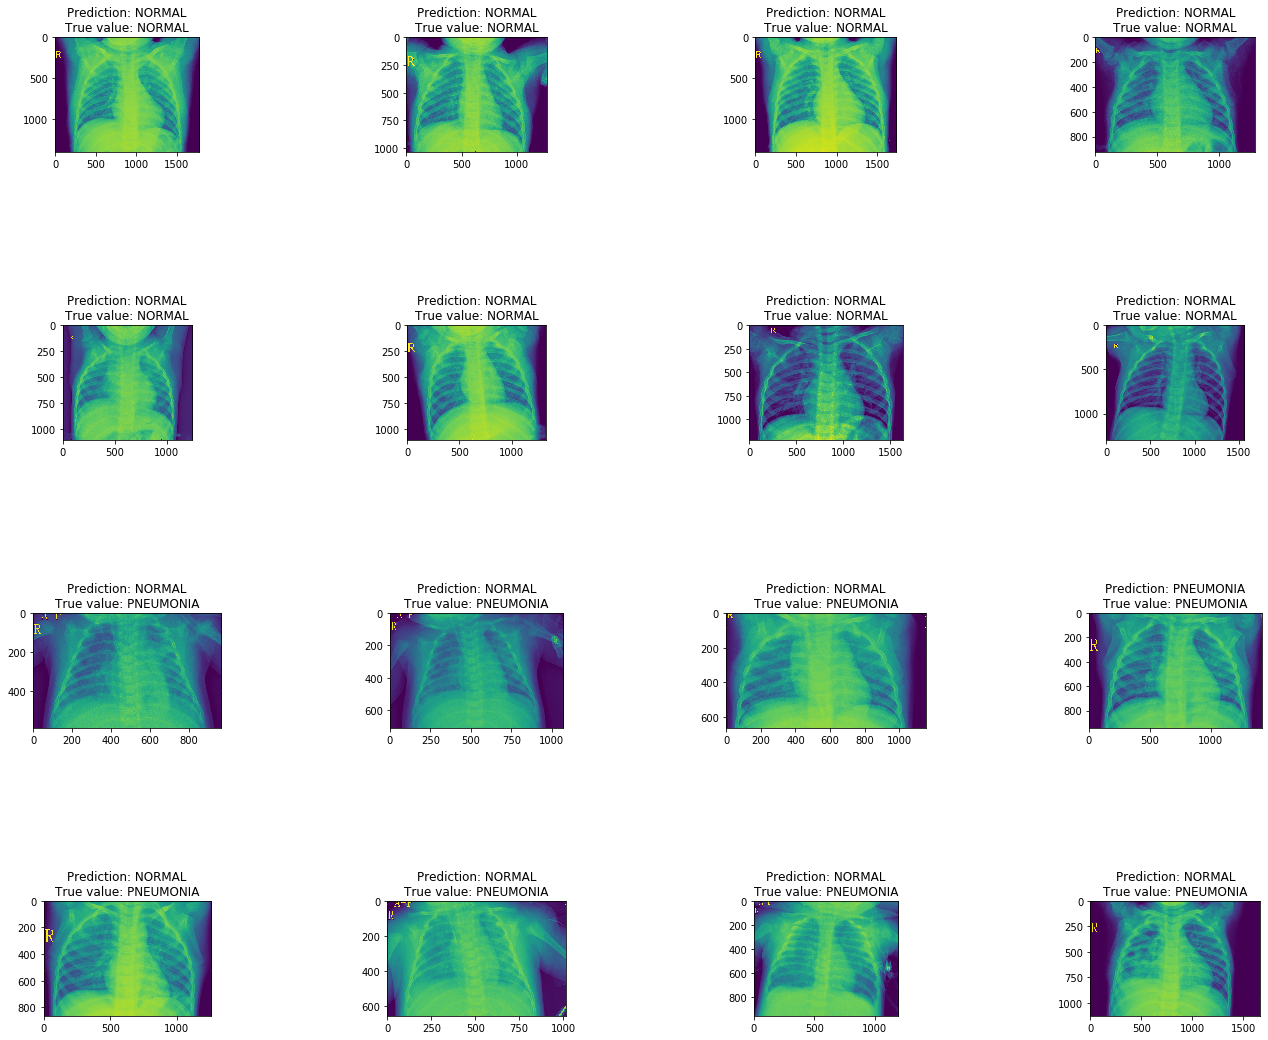

In [36]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))
compare_results(validation_dir, valid_generator)

### Tuning pass 2

In [37]:
model.fit_generator(generator = train_generator,epochs=7,validation_data=valid_generator)

Epoch 1/7
41/41 [==============================] - ETA: 1:10 - loss: 2.7316e-04 - accuracy: 1.00 - ETA: 58s - loss: 0.0035 - accuracy: 1.0000     - ETA: 51s - loss: 0.0024 - accuracy: 1.000 - ETA: 48s - loss: 0.0019 - accuracy: 1.000 - ETA: 46s - loss: 0.0017 - accuracy: 1.000 - ETA: 44s - loss: 0.0015 - accuracy: 1.000 - ETA: 43s - loss: 0.0015 - accuracy: 1.000 - ETA: 41s - loss: 0.0017 - accuracy: 1.000 - ETA: 39s - loss: 0.0015 - accuracy: 1.000 - ETA: 38s - loss: 0.0014 - accuracy: 1.000 - ETA: 36s - loss: 0.0014 - accuracy: 1.000 - ETA: 35s - loss: 0.0013 - accuracy: 1.000 - ETA: 34s - loss: 0.0013 - accuracy: 1.000 - ETA: 32s - loss: 0.0012 - accuracy: 1.000 - ETA: 31s - loss: 0.0018 - accuracy: 0.999 - ETA: 30s - loss: 0.0023 - accuracy: 0.999 - ETA: 28s - loss: 0.0022 - accuracy: 0.999 - ETA: 27s - loss: 0.0021 - accuracy: 0.999 - ETA: 26s - loss: 0.0021 - accuracy: 0.999 - ETA: 24s - loss: 0.0020 - accuracy: 0.999 - ETA: 23s - loss: 0.0019 - accuracy: 0.999 - ETA: 22s - loss:

41/41 [==============================] - ETA: 44s - loss: 0.0015 - accuracy: 1.000 - ETA: 42s - loss: 8.3669e-04 - accuracy: 1.000 - ETA: 42s - loss: 0.0061 - accuracy: 0.9974    - ETA: 41s - loss: 0.0049 - accuracy: 0.998 - ETA: 41s - loss: 0.0039 - accuracy: 0.998 - ETA: 39s - loss: 0.0034 - accuracy: 0.998 - ETA: 37s - loss: 0.0029 - accuracy: 0.998 - ETA: 36s - loss: 0.0025 - accuracy: 0.999 - ETA: 35s - loss: 0.0026 - accuracy: 0.999 - ETA: 34s - loss: 0.0025 - accuracy: 0.999 - ETA: 33s - loss: 0.0023 - accuracy: 0.999 - ETA: 32s - loss: 0.0021 - accuracy: 0.999 - ETA: 31s - loss: 0.0019 - accuracy: 0.999 - ETA: 30s - loss: 0.0029 - accuracy: 0.998 - ETA: 29s - loss: 0.0033 - accuracy: 0.998 - ETA: 28s - loss: 0.0031 - accuracy: 0.998 - ETA: 27s - loss: 0.0029 - accuracy: 0.998 - ETA: 26s - loss: 0.0029 - accuracy: 0.998 - ETA: 24s - loss: 0.0028 - accuracy: 0.998 - ETA: 23s - loss: 0.0026 - accuracy: 0.998 - ETA: 22s - loss: 0.0025 - accuracy: 0.998 - ETA: 21s - loss: 0.0027 - a

Validation accuracy after fine tuning: 0.625


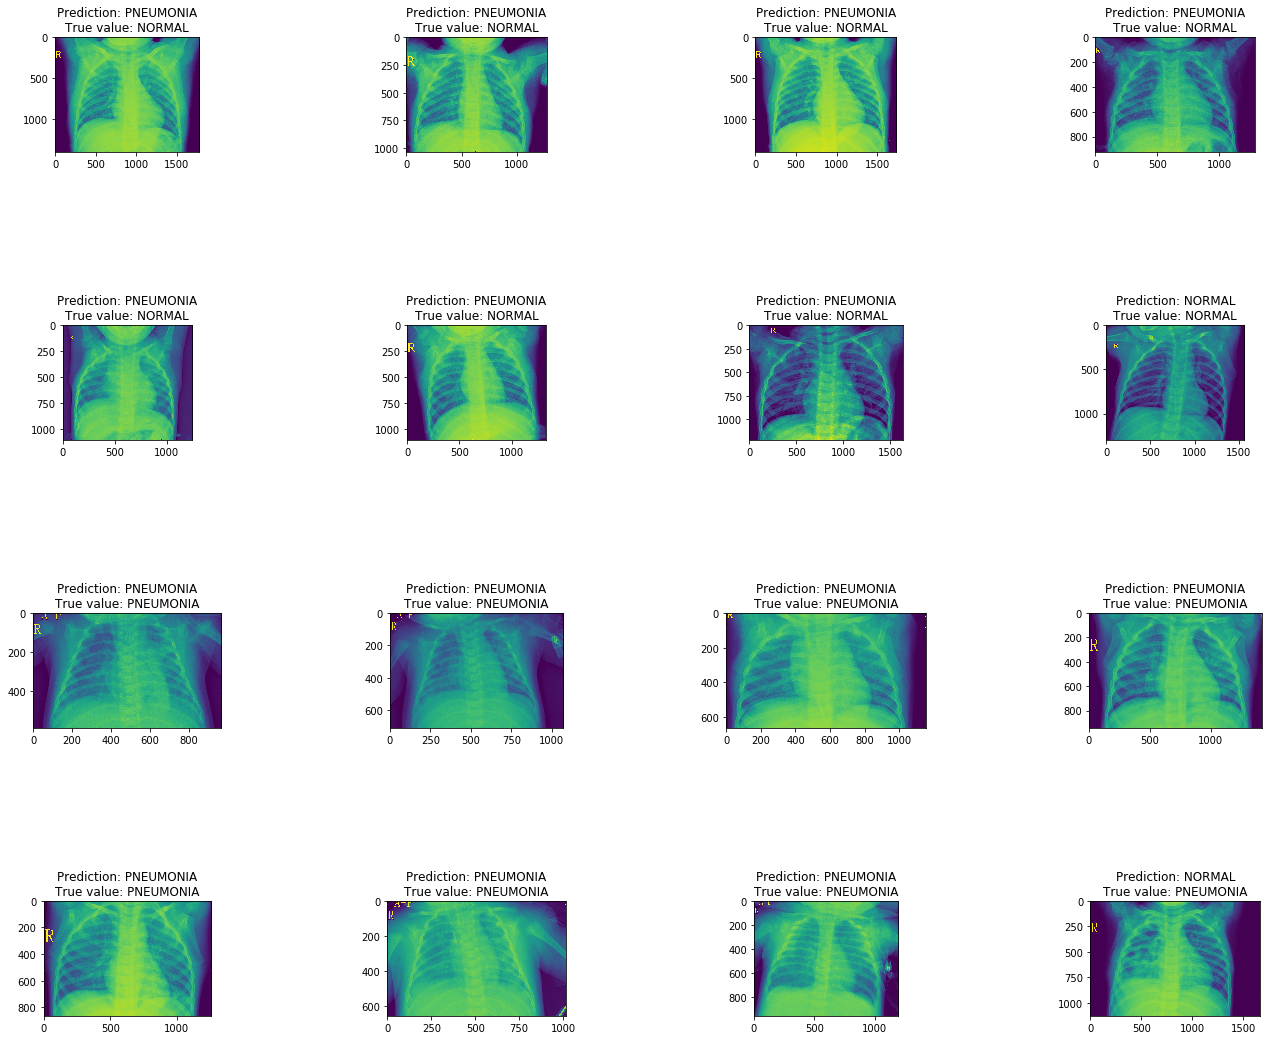

In [38]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))
compare_results(validation_dir, valid_generator)